 ### Data Ingestion, EDA and Visualization

* The AAVAIL datasets are used as a basis.
* Data ingestion, EDA and visualization in included below.

In [1]:
## all the imports you will need for this case study
import os
import pandas as pd
import numpy as np
import sqlite3

# specify the directory you saved the data in
data_dir = os.path.join(".","data")

In [2]:
def connect_db(file_path):
    try:
        conn = sqlite3.connect(file_path)
        print("...successfully connected to db\n")
    except Error as e:
        print("...unsuccessful connection\n",e)
    
    return(conn)

In [5]:
## make the connection to the database
conn = connect_db(os.path.join(data_dir,"aavail-customers.db"))

## print the table names
tables = [t[0] for t in conn.execute("SELECT name FROM sqlite_master WHERE type='table';")]
print(tables)

...successfully connected to db

['CUSTOMER', 'INVOICE', 'INVOICE_ITEM', 'COUNTRY']


Now that we have extracted the relevant data from the DB, let's query the database and extract the following data into a Pandas DataFrame.

In [6]:
query = """
SELECT cu.customer_id, cu.last_name, cu.first_name, cu.DOB,
       cu.city, cu.state, co.country_name, cu.gender
FROM CUSTOMER cu
INNER JOIN COUNTRY co
ON cu.country_id = co.country_id;
"""

_data = [d for d in conn.execute(query)]
columns = ["customer_id","last_name","first_name","DOB","city","state","country","gender"]
df_db = pd.DataFrame(_data,columns=columns)
df_db.head()

,customer_id,last_name,first_name,DOB,city,state,country,gender
0,1,Todd,Kasen,07/30/98,Rock Hill,South Carolina,united_states,m
1,2,Garza,Ensley,04/12/89,singapore,None,singapore,f
2,3,Carey,Lillian,09/12/97,Auburn,Alabama,united_states,f
3,4,Christensen,Beau,01/28/99,Hempstead,New York,united_states,m
4,5,Gibson,Ernesto,03/23/98,singapore,None,singapore,m


Let's extract the relevant data from the CSV file.

In [8]:
df_streams = pd.read_csv(os.path.join(data_dir,r"aavail-streams.csv"))
df_streams.head()

,customer_id,stream_id,date,invoice_item_id,subscription_stopped
0,1,1420.0,2018-10-21,2.0,0
1,1,1343.0,2018-10-23,2.0,0
2,1,1756.0,2018-11-05,2.0,0
3,1,1250.0,2018-11-06,2.0,0
4,1,1324.0,2018-11-12,2.0,0


Now we retrieve the data and create a churn table

In [9]:
customer_ids = df_streams['customer_id'].values
unique_ids = np.unique(df_streams['customer_id'].values)
streams = df_streams['subscription_stopped'].values
has_churned = [0 if streams[customer_ids==uid].max() > 0 else 1 for uid in unique_ids]
df_churn = pd.DataFrame({"customer_id": unique_ids,"is_subscriber": has_churned})
df_churn.head()

,customer_id,is_subscriber
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1


#### Exploratory Data Analysis

**Implementation of checks for Quality Assurance**

- Remove any repeat customers based on customer_id
- Remove stream data that do not have an associated stream_id
- Check for missing values

In [10]:
print("\nCleaning Summary\n{}".format("-"*35))
duplicate_rows = df_db.duplicated()

if True in duplicate_rows:
    df_db = df_db[~duplicate_rows]
print("Removed {} duplicate rows".format(np.where(duplicate_rows==True)[0].size))

missing_stream_ids = np.isnan(df_streams['stream_id'])    
if True in missing_stream_ids:
    df_streams = df_streams[~missing_stream_ids]
    
print("Removed {} missing stream ids".format(np.where(missing_stream_ids==True)[0].size))

print("\nMissing Value Summary\n{}".format("-"*35))
print("\ndf_db\n{}".format("-"*15))
print(df_db.isnull().sum(axis = 0))
print("\ndf_streams\n{}".format("-"*15))
print(df_streams.isnull().sum(axis = 0))


Cleaning Summary
-----------------------------------
Removed 7 duplicate rows
Removed 1164 missing stream ids

Missing Value Summary
-----------------------------------

df_db
---------------
customer_id      0
last_name        0
first_name       0
DOB              0
city             0
state          300
country          0
gender           0
dtype: int64

df_streams
---------------
customer_id             0
stream_id               0
date                    0
invoice_item_id         0
subscription_stopped    0
dtype: int64


**Combine the data into a single data structure**

In [11]:
import scipy.stats as stats

df_clean = df_churn.copy()
df_clean = df_clean[np.in1d(df_clean['customer_id'].values,df_db['customer_id'].values)]
unique_ids = df_clean['customer_id'].values

## ensure we are working with correctly ordered customer_ids df_db
if not np.array_equal(df_clean['customer_id'],df_db['customer_id']): 
    raise Exception("indexes are out of order or unmatched---needs to fix")

## query the db to create a invoice item map
query = """
SELECT i.invoice_item_id, i.invoice_item
FROM INVOICE_ITEM i;
"""

## variables for new df creation
invoice_item_map = {d[0]:d[1] for d in conn.execute(query)}
streams_stopped = df_streams['subscription_stopped'].values
streams_cid = df_streams['customer_id'].values
streams_iid = df_streams['invoice_item_id'].values
subscriber_invoice_mode = [stats.mode(streams_iid[streams_cid==uid])[0][0] for uid in unique_ids]

## create the new df
df_clean['country'] = df_db['country']
df_clean['age'] = np.datetime64('today') - pd.to_datetime(df_db['DOB'])
df_clean['customer_name'] = df_db['first_name'] + " " + df_db['last_name']
df_clean['subscriber_type'] = [invoice_item_map[int(sim)] for sim in subscriber_invoice_mode]
df_clean['num_streams'] = [streams_stopped[streams_cid==uid].size for uid in unique_ids]

## convert age to days
df_clean['age'] = [a.astype('timedelta64[Y]').astype(int) for a in df_clean['age'].values]

df_clean.head()

,customer_id,is_subscriber,country,age,customer_name,subscriber_type,num_streams
0,1,1,united_states,-29,Kasen Todd,aavail_premium,23
1,2,0,singapore,-20,Ensley Garza,aavail_unlimited,12
2,3,0,united_states,-28,Lillian Carey,aavail_premium,22
3,4,1,united_states,-30,Beau Christensen,aavail_basic,19
4,5,1,singapore,-29,Ernesto Gibson,aavail_premium,23


#### Data Visualization

In [12]:
#import Data Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
print(pd.crosstab(df_clean.is_subscriber, df_clean.country))

country        singapore  united_states
is_subscriber                          
0                    181            108
1                    119            592


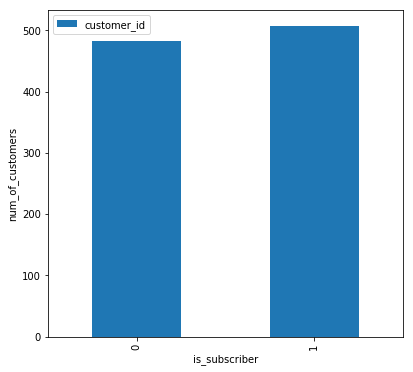

In [14]:
## Plot 1

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

table_c = pd.pivot_table(df_clean, index = ['is_subscriber'], values = 'customer_id')
table_c.plot(kind='bar',ax=ax1)
ax1.set_xlabel("is_subscriber");
ax1.set_ylabel("num_of_customers");

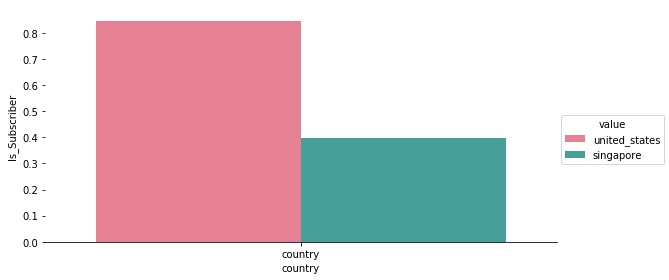

In [15]:
## Plot 2

# Create a new temporary dataframe to help us plot these variables.
df1 = pd.melt(df_clean, id_vars=['is_subscriber'], value_vars=["country"], var_name='country' )

# Create a factorplot
g = sns.factorplot( x="country", y="is_subscriber", hue='value', data=df1, size=4, aspect=2, kind="bar", palette="husl", ci=None )
g.despine(left=True)
g.set_ylabels("Is_Subscriber")
plt.show()

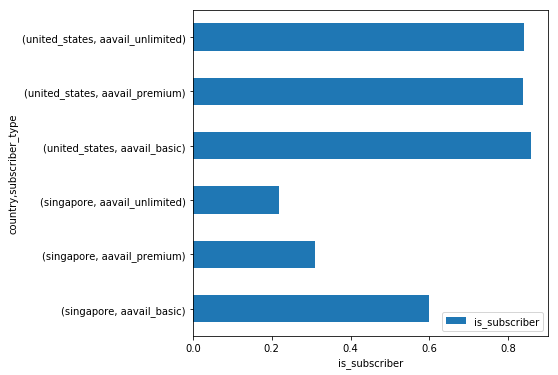

In [16]:
## Plot 3

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

table1 = pd.pivot_table(df_clean, index = ['country', 'subscriber_type'], values = 'is_subscriber')
table1.plot(kind='barh',ax=ax1)
ax1.set_xlabel("is_subscriber");

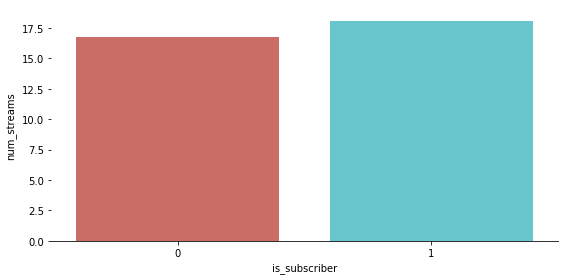

In [17]:
## Plot 4

# Create a factorplot
j = sns.factorplot( x="is_subscriber", y="num_streams", data=df_clean, size=4, aspect=2, kind="bar", palette= "hls", ci=None )
j.despine(left=True)
j.set_ylabels("num_streams")
plt.show()

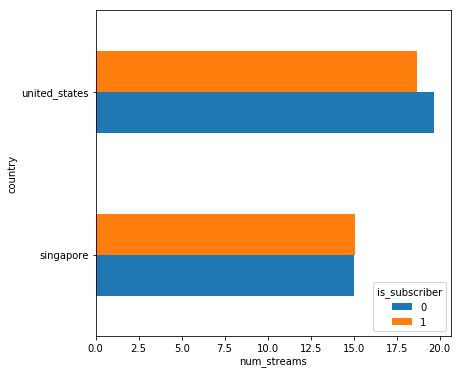

In [18]:
## Plot 5

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
table2 = df_clean.pivot_table('num_streams', index='country', columns='is_subscriber')
table2.plot(kind='barh',ax=ax1)
ax1.set_xlabel("num_streams");

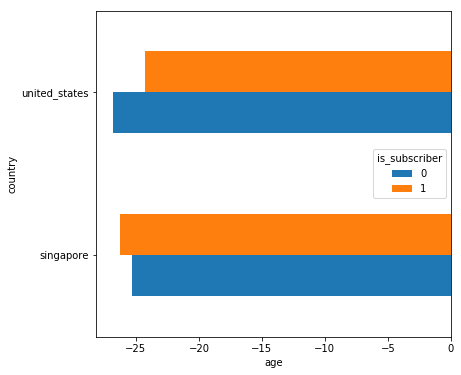

In [19]:
## Plot 6

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
table3 = df_clean.pivot_table('age', index='country', columns='is_subscriber')
table3.plot(kind='barh',ax=ax1)
ax1.set_xlabel("age");

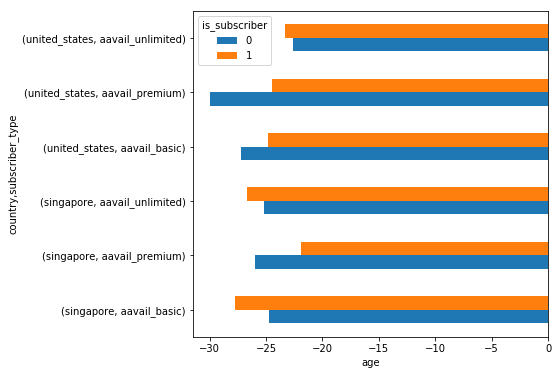

In [20]:
## Plot 7

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
table4 = df_clean.pivot_table('age', index=['country','subscriber_type'], columns='is_subscriber')
table4.plot(kind='barh',ax=ax1)
ax1.set_xlabel("age");

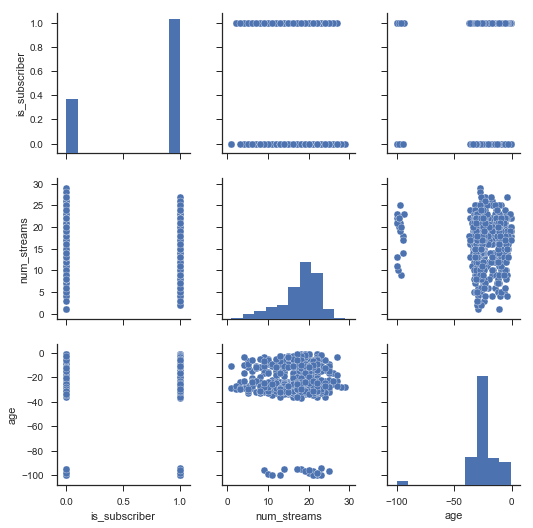

In [21]:
## Plot 8

import seaborn as sns
sns.set(style="ticks", color_codes=True)

## make a pair plot
columns = ['is_subscriber', 'num_streams', 'age']

axes = sns.pairplot(df_clean, vars=columns, palette="husl")